# 4 Seminar

Hi! Today we are going to learn about image segmentation and object detection. We'll write and train some simple neural models for image segmentation, and look how object detection models work.


In [ ]:
!pip install catalyst

In [ ]:
from catalyst.utils import set_global_seed

In [ ]:
set_global_seed(42)

## Segmentation

### Dataset

Look at the today task: cell segmentation! It's the dataset [ADDI](https://www.fc.up.pt/addi/ph2%20database.html). The dataset contained medical photo of skin with a mole or a melonoma. We'll just segment them on photo, without classification.

<table><tr><td>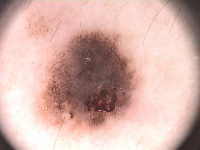</td><td>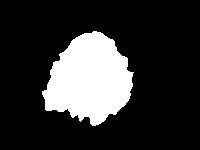</td></tr></table>

Download the archive and uncompess it.



In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

// File structure

// Let's show the images

In [ ]:
import os
from pathlib import Path

from cv2 import erode
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate, rescale

import catalyst
import catalyst.dl as dl
from catalyst.utils import imread

In [ ]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

images = np.array(images)
lesions = np.array(lesions)

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].imshow(images[0])
ax[1].imshow(lesions[0])

In [ ]:
thr = 0.5

example_lesion = (lesions[0] / 255).mean(2)
transformed_lesion = (rotate(example_lesion, 40) > thr) * 1.0

_, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].imshow(example_lesion, cmap="gray")
ax[1].imshow(transformed_lesion, cmap="gray")

### IoU

![iou](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

In [ ]:
intersection = # Calculate intersection

_, ax = plt.subplots(1, 3, figsize=(15, 10))

red_true = np.concatenate(
    [example_lesion[:, :, np.newaxis], np.zeros(example_lesion.shape + (2,))],
    axis=2,
)
blue_fake = np.concatenate(
    [
        np.zeros(example_lesion.shape + (2,)),
        transformed_lesion[:, :, np.newaxis],
    ],
    axis=2,
)

ax[0].imshow(red_true)
ax[1].imshow((intersection[:,:,np.newaxis] * 0.5 + red_true + blue_fake))
ax[2].imshow(blue_fake)

In [ ]:
union = # Calculate union

_, ax = plt.subplots(1, 3, figsize=(15, 10))

red_true = np.concatenate(
    [example_lesion[:, :, np.newaxis], np.zeros(example_lesion.shape + (2,))],
    axis=2,
)
blue_fake = np.concatenate(
    [
        np.zeros(example_lesion.shape + (2,)),
        transformed_lesion[:, :, np.newaxis],
    ],
    axis=2,
)

ax[0].imshow(red_true)
ax[1].imshow(union, cmap="gray")
ax[2].imshow(blue_fake)

In [ ]:
iou = np.sum(intersection) / np.sum(union)
print(f"Current IoU: {iou}")

In [ ]:
# Is it loss?
intersection_l = # Calculate "smooth" intersection
union_l = # Calculate "smooth" union
iou_l = np.sum(intersection_l) / np.sum(union_l)

print(f"IoU: {iou_l}, Current IoU Loss: {1 - iou_l}")

In [ ]:
import torch
from catalyst.utils.metrics.iou import iou


print(f"IoU {iou(torch.from_numpy(transformed_lesion), torch.from_numpy(example_lesion), activation=None)}")

### Dice

![](https://miro.medium.com/max/858/1*yUd5ckecHjWZf6hGrdlwzA.png)

In [ ]:
intersection = # Calculate intersection

recall = # Calculate recall
precision = # Calculate precision
print(f"Recall: {recall}. Precision: {precision}")

In [ ]:
f1 = # Calculate f1
print(f"F1: {f1}")

In [ ]:
f1 = (
    # Rewrite formula with intersection, predictions and ground truth
)
print(f"Another F1: {f1}. It's DICE!")

In [ ]:
from catalyst.utils.metrics.dice import dice


print(f"Dice {dice(torch.from_numpy(transformed_lesion), torch.from_numpy(example_lesion), activation=None)}")

### Morphological Transformations


Morphological transformation is a useful toolkit to enhance maskes or semantic maps. If a mask is noisy, we can remove error points by erosion.

In [ ]:
thr =  0.5

transformed_lesion = rotate(example_lesion, 40) * 1.0
noise = np.random.randn(*(s // 20 for s in example_lesion.shape))
noise = rescale(noise, 30)[
    : example_lesion.shape[0], : example_lesion.shape[1]
]
noised_mask = 0.7 * transformed_lesion + 0.3 * noise
noised_mask = (noised_mask - noised_mask.min()) / (
    noised_mask.max() - noised_mask.min()
)

_, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(example_lesion, cmap="gray")
ax[1].imshow(transformed_lesion > thr, cmap="gray")
ax[2].imshow(noised_mask > thr, cmap="gray")

How erosion works?

In [ ]:
kernel = np.ones((3, 3)).astype(np.uint8)
print(f"Kernel:\n{kernel}")

example = np.ones((10, 10))
example[3, 4] = 0
print(f"Example:\n{example}")

padded_example = np.zeros((12, 12))
padded_example[1:11, 1:11] = example
result = np.zeros((10, 10)) 
for i in range(10):
    for j in range(10):
        result[i, j] = np.min(padded_example[i:i + 3, j:j + 3] * kernel)

print(f"Result:\n{result}")

Let's use it.


In [ ]:
kernel = np.ones((5, 5)).astype(np.uint8)
eroded = (
    erode((noised_mask * 255).astype(np.uint8), kernel, iterations=5) / 255
)

_, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(example_lesion, cmap="gray")
ax[1].imshow(noised_mask > thr, cmap="gray")
ax[2].imshow(eroded > thr, cmap="gray")

## Data Augmentation


In [ ]:
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(self, images=None, masks=None, transforms=None) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image = self.images[idx]

        result = {"image": image}

        if self.masks is not None:
            result["mask"] = self.masks[idx].mean(2).astype(int) // 255

        if self.transforms is not None:
            result = self.transforms(**result)

        return result

In [ ]:
import albumentations as albu
from albumentations.pytorch import ToTensor


def pre_transform(image_size: int = 224):
    return albu.Resize(224, 224, p=1)


def augmentations(image_size: int = 224):
    channel_augs = [
        albu.HueSaturationValue(p=0.5),
        albu.ChannelShuffle(p=0.5),
    ]

    result = [
        albu.OneOf(
            [albu.IAAAdditiveGaussianNoise(), albu.GaussNoise(),], p=0.5
        ),
        albu.OneOf(
            [
                albu.MotionBlur(blur_limit=3, p=0.7),
                albu.MedianBlur(blur_limit=3, p=1.0),
                albu.Blur(blur_limit=3, p=0.7),
            ],
            p=0.5,
        ),
        albu.OneOf(channel_augs),
        albu.OneOf(
            [albu.CLAHE(clip_limit=2), albu.IAASharpen(), albu.IAAEmboss(),],
            p=0.5,
        ),
        albu.RandomBrightnessContrast(
            brightness_limit=0.5, contrast_limit=0.5, p=0.5
        ),
        albu.RandomGamma(p=0.5),
        albu.OneOf([albu.MedianBlur(p=0.5), albu.MotionBlur(p=0.5)]),
        albu.RandomGamma(gamma_limit=(85, 115), p=0.5),
    ]
    return albu.Compose(result)


def post_transform():
    return albu.Compose([albu.Normalize(), ToTensor()])

In [ ]:
train_transformation = albu.Compose(
    # Create train pipeline
)

valid_transformation = albu.Compose(
    # Create valid pipeline
)

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(15, 15))

for i in range(4):
    aug_image = train_transformation(image=images[0])["image"].permute(1, 2, 0).numpy()
    ax[i % 2][i // 2].imshow(aug_image)

In [ ]:
from torch.utils.data import DataLoader, random_split


batch_size = 8
num_workers = 4


indexes = np.arange(len(images))
np.random.shuffle(indexes)
train_indexes = indexes[:int(0.8 * len(images))]
valid_indexes = indexes[int(0.8 * len(images)):]


train_loader = DataLoader(
    # Create train loader
)

valid_loader = DataLoader(
    # Create valid loader
)

loaders = {"train": train_loader, "valid": valid_loader}

### U-Net

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [ ]:
import torch
import torch.nn as nn


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Write model code !

    def forward(self, image):
        # Propagate image through model
        return output

In [ ]:
from catalyst.contrib.nn.optimizers.radam import RAdam
from catalyst.contrib.nn.criterion import DiceLoss, IoULoss


model = UNet()
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}
optimizer = RAdam(model.parameters(), lr=1e-3)
callbacks = [
    dl.CriterionCallback(
        input_key="mask", prefix="loss_dice", criterion_key="dice"
    ),
    dl.CriterionCallback(
        input_key="mask", prefix="loss_iou", criterion_key="iou"
    ),
    dl.CriterionCallback(
        input_key="mask", prefix="loss_bce", criterion_key="bce"
    ),
    dl.MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum",
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),
    dl.DiceCallback(input_key="mask"),
    dl.IouCallback(input_key="mask"),
]

In [ ]:
from datetime import datetime


runner = dl.SupervisedRunner(input_key="image", input_target_key="mask")


runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=callbacks,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=10,
    main_metric="iou",
    minimize_metric=False,
    verbose=True,
)

Let's look at the mask!

In [ ]:
from torch.nn.functional import interpolate


pt_image = valid_transformation(image=images[0])["image"].unsqueeze(0).cuda()
model.eval()

pt_mask = torch.sigmoid(model(pt_image).detach().cpu())
pt_mask = interpolate(pt_mask, images[0].shape[:-1]).squeeze()
example_mask = pt_mask.squeeze().numpy()


_, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(images[0])
ax[1].imshow(lesions[0])
ax[2].imshow(example_mask, cmap='gray')

### FCN & Transfer Learning

Using a pretrained ResNet model as a backbone for our segmentation model.

![FCN](http://deeplearning.net/tutorial/_images/cat_segmentation.png)

In [ ]:
class FCN(nn.Module):
    def __init__(
        self, pretrained_model, output_channel, image_size=224, p=0.1
    ):
        super().__init__()

        self.pretrained_model = pretrained_model
        self.output_channel = output_channel
        self.image_size = image_size
        self.p = p

        self.deconv = nn.Sequential(
            *(
                self.make_up_block_(self.output_channel // d)
                for d in [1, 4, 16, 64, 256]
            )
        )

        self.output = nn.Conv2d(1, 1, kernel_size=7, stride=1, padding=3, bias=False)

    def make_up_block_(self, output_channel):
        return # Create upsampling block!

    def forward(self, image):
        features = self.pretrained_model(image)
        mask = self.deconv(features)
        return self.output(mask)

In [ ]:
from torchvision.models import mobilenet_v2


pretrained_model = mobilenet_v2(pretrained=True)
model = FCN(pretrained_model.features, 1280, 512)
optimizer = RAdam(model.parameters(), lr=1e-3)

runner = dl.SupervisedRunner(input_key="image", input_target_key="mask")
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=callbacks,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=10,
    main_metric="iou",
    minimize_metric=False,
    verbose=True,
)

In [ ]:
pt_image = valid_transformation(image=images[0])["image"].unsqueeze(0).cuda()
model.eval()

pt_mask = torch.sigmoid(model(pt_image).detach().cpu())
pt_mask = interpolate(pt_mask, images[0].shape[:-1]).squeeze()
example_mask = pt_mask.squeeze().numpy()


_, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(images[0])
ax[1].imshow(lesions[0])
ax[2].imshow(example_mask, cmap='gray')

### Catalyst.Contrib

Catalyst already has a segmentation models generator.
There is a huge variety of model architectures, let's try one of them!

In [ ]:
from catalyst.contrib.models.cv.segmentation.unet import Unet

model = Unet()
optimizer = RAdam(model.parameters(), lr=1e-3)

runner = dl.SupervisedRunner(input_key="image", input_target_key="mask")
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=callbacks,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=10,
    main_metric="iou",
    minimize_metric=False,
    verbose=True,
)

In [ ]:
pt_image = valid_transformation(image=images[0])["image"].unsqueeze(0).cuda()
model.eval()

pt_mask = torch.sigmoid(model(pt_image).detach().cpu())
pt_mask = interpolate(pt_mask, images[0].shape[:-1]).squeeze()
example_mask = pt_mask.squeeze().numpy()


_, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(images[0])
ax[1].imshow(lesions[0])
ax[2].imshow(example_mask, cmap='gray')

## Object Detection

This part based on tutorial from [github](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection).

 Firstly download all necessary files. They contain a codebase, finetuned model's state dict and fonts for showing bounding boxes.




In [ ]:
!git clone https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection
!mv a-PyTorch-Tutorial-to-Object-Detection/* .
!gdown https://drive.google.com/uc?id=1zmx5FXcnE9WC_rIZhh0qsy8Zom32YwNz&export=download
!unzip Calibri_Font_Family.zip
!gdown https://drive.google.com/uc?id=1bvJfF6r_zYl2xZEpYXxgb7jLQHFZ01Qe&export=download

Choose the victim. Object detection usualy is used for self-driving cars, so try to detect pedectrians on a  photo.

In [ ]:
!wget https://www1.nyc.gov/html/dot/images/pedestrians/ped-ramps-bay-ridge-ave.jpg

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy

original_image = Image.open('ped-ramps-bay-ridge-ave.jpg', mode='r')
original_image = original_image.convert('RGB')

plt.figure(figsize=(15, 10))
plt.imshow(original_image)

Prepare the image and the model.

In [ ]:
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont

from model import SSD300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint, map_location_device=device)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = SSD300(checkpoint['model'].n_classes)
model.load_state_dict(checkpoint['model'].state_dict())
model = model.to(device)
model.eval()

# Transforms
resize = # Create resize transformer image to (300, 300)
to_tensor = # Create torch transformer
normalize = # Create normalizer

In [ ]:
Get model predictions. Object detection models usually returns class probabilities and bounding boxes predictions.

In [ ]:
image = normalize(to_tensor(resize(original_image)))

# Move to default device
image = image.to(device)

# Forward prop.
predicted_locs, predicted_scores = model(image.unsqueeze(0))

Let's look into predicted locs and labels.

In [ ]:
print(f"Locs shape: {predicted_locs.size()[1:]}, scores shape: {predicted_scores.size()[1:]}")

annotated_image = deepcopy(original_image)
draw = ImageDraw.Draw(annotated_image)

decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[0], model.priors_cxcy)).cpu().detach()

original_dims = torch.FloatTensor(
    [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
decoded_locs = # Map locations to original image

for box_loc in decoded_locs[::10]:
    box_loc = box_loc.numpy()
    draw.rectangle(xy=[l + 1. for l in box_loc], outline="black") 

plt.figure(figsize=(15, 10))
plt.imshow(annotated_image)

Filter boxes by on model confidence.

In [ ]:
probs = F.softmax(predicted_scores[0], dim=1)
# First class – background
best_scores, best_cls = # Find the best class for each box

filtered = decoded_locs[best_scores >= 0.2]
print(f"Filtered locations: {len(filtered)}")

annotated_image = deepcopy(original_image)
draw = ImageDraw.Draw(annotated_image)

for box_loc in filtered:
    box_loc = box_loc.numpy()
    draw.rectangle(xy=[l for l in box_loc], outline="black")


plt.figure(figsize=(15, 10))
plt.imshow(annotated_image)

Calculate IoU(or Jaccard index, same things) to find overlapping boxes.
This is the Non-Maximum Suppression algorithm.

In [ ]:
annotated_image = deepcopy(original_image)
draw = ImageDraw.Draw(annotated_image)

filtered_scores = best_scores[best_scores > 0.2]
filtered_cls = best_cls[best_scores > 0.2]

result_box = []
result_cls = []

for c in range(0, model.n_classes):
    _, indeces = # Filter scores and sort them from bigger to smaller
    cls_boxes = filtered[filtered_cls == c]
    cls_boxes = cls_boxes[indeces]
    overlap = find_jaccard_overlap(cls_boxes, cls_boxes)

    suppress = torch.zeros(cls_boxes.size(0), dtype=torch.uint8)
    for i in range(cls_boxes.size(0)):
        if suppress[i] == 1:
            continue

        condition = overlap[i] > 0.5
        condition = torch.tensor(condition, dtype=torch.uint8)
        suppress = torch.max(suppress, condition) 

        suppress[i] = 0

    for s, box in zip(suppress, cls_boxes):
        if s < 1:
            result_box.append(box)
            result_cls.append(c)

print(f"After another filter: {len(result_box)} boxes")
for box_loc in result_box:
    box_loc = box_loc.numpy()
    draw.rectangle(xy=[l for l in box_loc], outline="black") 

plt.figure(figsize=(15, 10))
plt.imshow(annotated_image)

And the last task is creating annotations!

In [ ]:
annotated_image = deepcopy(original_image)
draw = ImageDraw.Draw(annotated_image)
font = ImageFont.truetype("./Calibri 400.ttf", 15)

for i in range(len(result_box)):
    box_location = result_box[i].numpy()
    label = rev_label_map[result_cls[i] + 1]
    draw.rectangle(xy=box_location, outline=label_color_map[label])
    draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[label]) 

    text_size = font.getsize(label.upper())
    text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
    textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                        box_location[1]]
    draw.rectangle(xy=textbox_location, fill=label_color_map[label])
    draw.text(xy=text_location, text=label.upper(), fill='white',
                font=font)
    
plt.figure(figsize=(15, 10))
plt.imshow(annotated_image)

### Extras
Change model from the old SSD300 to the modern EfficientDet.
Implementation and pretrained model's weights you can find in [@toandaominh1997/EfficientDet.Pytorch](https://github.com/toandaominh1997/EfficientDet.Pytorch).